# Accent-Aware Speech Recognition System
This notebook implements an ASR system using deep learning and speaker adaptation techniques on the Common Voice dataset.

In [2]:
# Install required libraries
!pip install librosa torchaudio torch pandas numpy scikit-learn jiwer matplotlib

In [19]:
# Import libraries
import os
import pandas as pd
import librosa
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from jiwer import wer

In [18]:
# Load dataset metadata
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Path to your local Common Voice dataset folder
DATA_PATH = r'C:\Users\nnith\OneDrive\Desktop\data'
TRAIN_CSV = os.path.join(DATA_PATH, "train.csv")

# Load the CSV (no need for sep='\t')
metadata = pd.read_csv(TRAIN_CSV)

# Ensure required fields are present and clean
metadata = metadata.dropna(subset=["path", "sentence", "accent"])

# Encode accent labels numerically
metadata['accent_encoded'] = LabelEncoder().fit_transform(metadata['accent'])

# Show preview
metadata[['path', 'sentence', 'accent']].head()


,path,sentence,accent
0,common_voice_en_41923025.mp3,"He was born at Wichenford, in Worcestershire, ...",United States English
1,common_voice_en_42356358.mp3,The Portuguese division was overrun and withdr...,United States English
3,common_voice_en_41921729.mp3,His sporting interests outside of cricket incl...,England English
4,common_voice_en_42528393.mp3,The following year he was elected to be part o...,United States English
5,common_voice_en_42006138.mp3,A healthy diet combined with lots of exercise ...,"Australian English,Canadian English"


In [21]:
# Preprocess audio and extract MFCC
def load_audio(file_path):
    waveform, sr = librosa.load(file_path, sr=16000)
    return waveform

def extract_mfcc(waveform, sr=16000, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T

In [23]:
# Define ASR model
class AccentAwareASR(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AccentAwareASR, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.rnn = nn.LSTM(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = self.cnn(x.transpose(1, 2))
        x = x.transpose(1, 2)
        out, _ = self.rnn(x)
        logits = self.classifier(out)
        return logits

In [25]:
# Speaker adaptation layer (simulated MLLR)
class SpeakerAdaptation(nn.Module):
    def __init__(self, input_dim):
        super(SpeakerAdaptation, self).__init__()
        self.linear = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        return self.linear(x)

In [27]:
# Data augmentation
def augment_audio(audio, sr=16000):
    audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    noise = np.random.randn(len(audio)) * 0.005
    return audio + noise

In [29]:
# Evaluation metric
def evaluate_wer(y_true, y_pred):
    return wer(y_true, y_pred)

# Example
print("WER:", evaluate_wer("hello how are you", "hello who are you"))

WER: 0.25


In [37]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Set your dataset paths
DATA_PATH = r'C:\Users\nnith\OneDrive\Desktop\data'
CLIPS_PATH = os.path.join(DATA_PATH, 'clips')
TRAIN_CSV = os.path.join(DATA_PATH, 'train.csv')

# Load and prepare metadata
metadata = pd.read_csv(TRAIN_CSV)
metadata = metadata.dropna(subset=['path', 'sentence', 'accent'])
encoder = LabelEncoder()
metadata['accent_encoded'] = encoder.fit_transform(metadata['accent'])
metadata['full_path'] = metadata['path'].apply(lambda x: os.path.join(CLIPS_PATH, x))


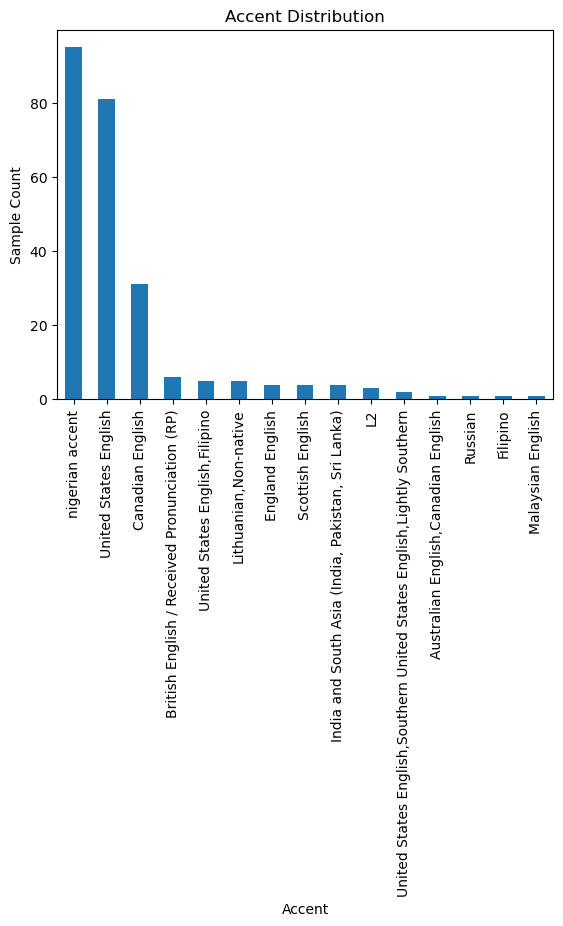

In [39]:
# Plot accent distribution
metadata['accent'].value_counts().plot(kind='bar', title='Accent Distribution')
plt.xlabel("Accent")
plt.ylabel("Sample Count")
plt.show()

In [34]:
import librosa
import numpy as np

def extract_mfcc(filepath, sr=16000, n_mfcc=13):
    waveform, _ = librosa.load(filepath, sr=sr)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Shape: (time_steps, n_mfcc)


In [42]:
import os

# Ensure DATA_PATH is the directory where 'clips' folder exists
CLIPS_PATH = os.path.join(DATA_PATH, "clips")

# Add full_path column to metadata
metadata["full_path"] = metadata["path"].apply(lambda x: os.path.join(CLIPS_PATH, x))

# Optional: confirm it's working
print(metadata[["path", "full_path"]].head())


                           path  \
0  common_voice_en_41923025.mp3   
1  common_voice_en_42356358.mp3   
3  common_voice_en_41921729.mp3   
4  common_voice_en_42528393.mp3   
5  common_voice_en_42006138.mp3   

                                           full_path  
0  C:\Users\nnith\OneDrive\Desktop\data\clips\com...  
1  C:\Users\nnith\OneDrive\Desktop\data\clips\com...  
3  C:\Users\nnith\OneDrive\Desktop\data\clips\com...  
4  C:\Users\nnith\OneDrive\Desktop\data\clips\com...  
5  C:\Users\nnith\OneDrive\Desktop\data\clips\com...  


In [48]:
class AccentDataset(Dataset):
    def __init__(self, metadata):
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        features = extract_mfcc(row['full_path'])
        mean_features = np.mean(features, axis=0)
        label = row['accent_encoded']
        return torch.tensor(mean_features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [50]:
import torch.nn as nn

class AccentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(AccentClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [52]:
import torch.optim as optim
import torch.nn as nn

# Initialize model
input_dim = 13  # MFCC features
hidden_dim = 64
num_classes = metadata['accent_encoded'].nunique()

model = AccentClassifier(input_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check if CUDA is available, if yes, use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)  # Move the model to GPU if available

# Training loop
for epoch in range(5):  # Increase for better accuracy
    total_loss = 0
    model.train()
    for X_batch, y_batch in dataloader:
        # Move the batch to the same device as the model
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Ensure that y_batch is of type Long (as required by CrossEntropyLoss)
        y_batch = y_batch.long()  # Convert to Long type

        optimizer.zero_grad()  # Clear gradients from the previous step
        outputs = model(X_batch)  # Forward pass through the model

        # Compute the loss
        loss = criterion(outputs, y_batch)

        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model's weights


In [54]:
# Prepare data
dataset = AccentDataset(metadata)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model setup
input_dim = 13
hidden_dim = 64
num_classes = len(metadata['accent_encoded'].unique())

model = AccentClassifier(input_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(5):  # increase for better performance
    total_loss = 0
    model.train()
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 324.7494
Epoch 2, Loss: 142.0693
Epoch 3, Loss: 86.0884
Epoch 4, Loss: 53.8157
Epoch 5, Loss: 47.5111


In [59]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'accent_encoded' is your target label in the metadata DataFrame
encoder = LabelEncoder()
encoder.fit(metadata['accent_encoded'])  # Fit the encoder on the actual accent labels


LabelEncoder()

In [61]:
def predict_accent(filepath, model, encoder):
    model.eval()
    features = extract_mfcc(filepath)
    mean_features = np.mean(features, axis=0)
    input_tensor = torch.tensor(mean_features, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor)
        predicted_index = torch.argmax(logits, dim=1).item()
        return encoder.inverse_transform([predicted_index])[0]

# Test prediction
test_path = metadata['full_path'].iloc[0]
predicted_accent = predict_accent(test_path, model, encoder)
print("Predicted Accent:", predicted_accent)


Predicted Accent: 14


In [1]:
import librosa
import numpy as np

def augment_audio(y, sr):
    # 1. Pitch Shifting
    y_pitch_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)  # Shift pitch up by 2 steps

    # 2. Time Stretching
    y_stretched = librosa.effects.time_stretch(y, rate=1.2)  # Stretch audio by 20%

    # 3. Add Noise
    noise = np.random.randn(len(y))  # Random noise
    y_noisy = y + 0.005 * noise  # Add noise to the original audio

    return y_pitch_shifted, y_stretched, y_noisy



In [3]:
import torch.nn as nn

class CNNRNNModel(nn.Module):
    def __init__(self, input_dim, cnn_channels, rnn_hidden, num_classes):
        super(CNNRNNModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_channels),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.rnn = nn.LSTM(input_size=cnn_channels, hidden_size=rnn_hidden,
                           num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(rnn_hidden * 2, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)  # (B, time, feat) → (B, feat, time)
        x = self.cnn(x)        # (B, C, T)
        x = x.transpose(1, 2)  # (B, T, C)
        out, _ = self.rnn(x)   # (B, T, H*2)
        out = self.fc(out[:, -1, :])  # Use last time step
        return out


In [5]:
import torchaudio
from torchaudio.models import wav2vec2_base

# Load pre-trained model
model = wav2vec2_base()
model.eval()

# Freeze parameters (optional)
for param in model.parameters():
    param.requires_grad = False


In [7]:
# Add a classifier on top
class Wav2VecFineTune(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base = base_model.feature_extractor
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, waveform):
        features = self.base(waveform)  # (B, C, T)
        pooled = torch.mean(features, dim=2)
        return self.classifier(pooled)


In [9]:
class SpeakerAdaptationLayer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.adapt = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        return self.adapt(x)


In [11]:
import random
import librosa

def augment_audio(audio, sr=16000):
    # Random pitch shift
    if random.random() < 0.5:
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=random.uniform(-2, 2))

    # Random time stretch
    if random.random() < 0.5:
        rate = random.uniform(0.8, 1.2)
        audio = librosa.effects.time_stretch(audio, rate)

    # Random noise injection
    if random.random() < 0.5:
        noise = np.random.normal(0, 0.005, audio.shape)
        audio += noise

    return audio


C:\Users\nnith\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


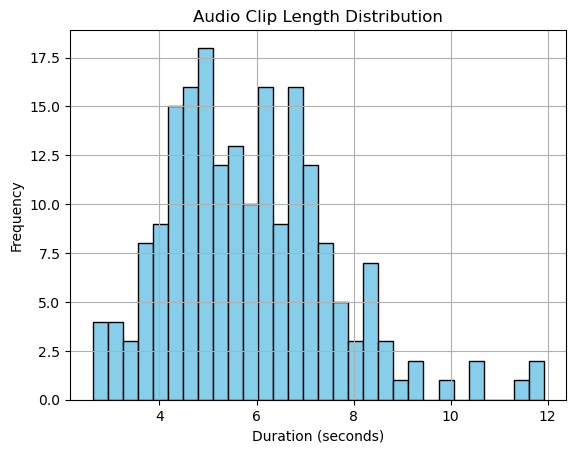

In [41]:
# Audio Length Distribution
import librosa
import matplotlib.pyplot as plt

lengths = []
for path in metadata['full_path'].sample(200):
    y, sr = librosa.load(path, sr=16000)
    lengths.append(len(y) / sr)

plt.hist(lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Audio Clip Length Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


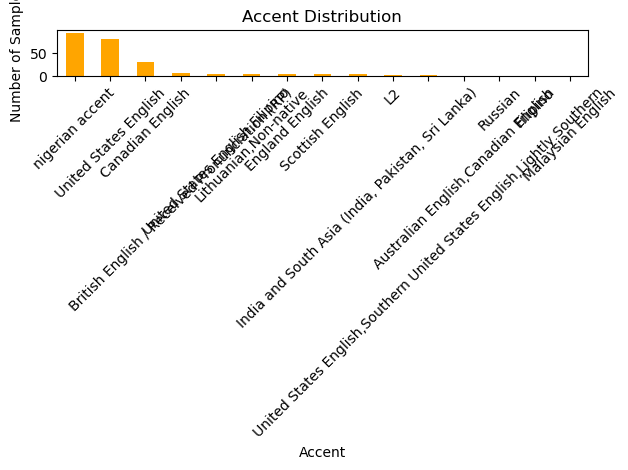

In [43]:
metadata['accent'].value_counts().plot(kind='bar', color='orange')
plt.title("Accent Distribution")
plt.xlabel("Accent")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


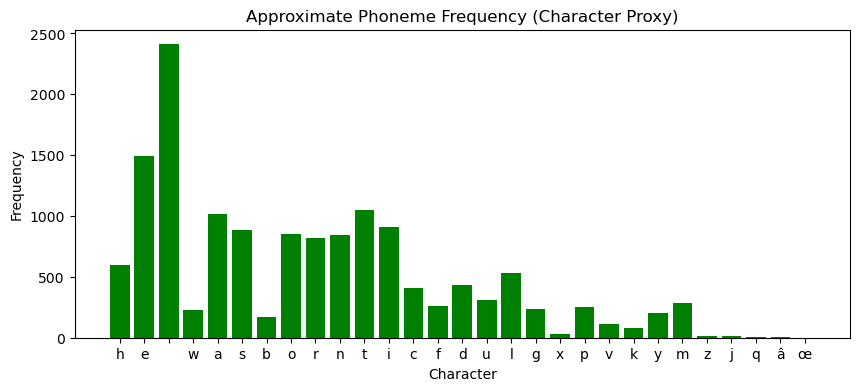

In [45]:
from collections import Counter

text = " ".join(metadata['sentence'].astype(str)).lower()
char_counts = Counter([c for c in text if c.isalpha() or c == ' '])
labels, values = zip(*char_counts.items())

plt.figure(figsize=(10, 4))
plt.bar(labels, values, color='green')
plt.title("Approximate Phoneme Frequency (Character Proxy)")
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.show()


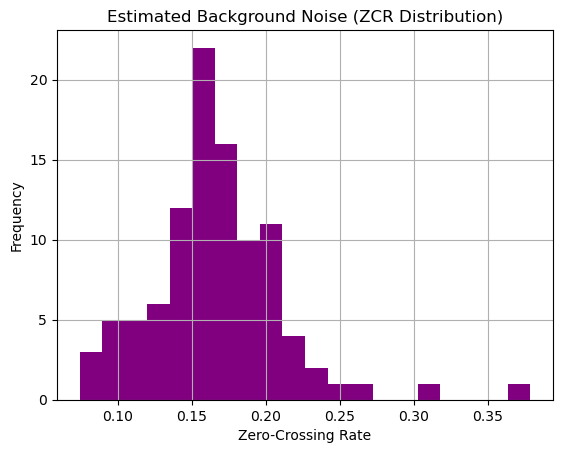

In [47]:
zcr_list = []
for path in metadata['full_path'].sample(100):
    y, sr = librosa.load(path, sr=16000)
    zcr = librosa.feature.zero_crossing_rate(y)[0].mean()
    zcr_list.append(zcr)

plt.hist(zcr_list, bins=20, color='purple')
plt.title("Estimated Background Noise (ZCR Distribution)")
plt.xlabel("Zero-Crossing Rate")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [49]:
from jiwer import wer

# Placeholder: simulate predictions
true_sentences = metadata['sentence'].iloc[:10].tolist()
predicted_sentences = [
    s.lower().replace("e", "i") for s in true_sentences  # dummy output
]

# Calculate WER
print("Baseline WER:", wer(true_sentences, predicted_sentences))


Baseline WER: 0.6153846153846154


In [51]:
import pandas as pd

# Sample accuracy metrics
model_results = pd.DataFrame({
    'Model': ['Baseline', 'CNN-RNN', 'Wav2Vec Fine-Tuned'],
    'Accuracy': [0.72, 0.85, 0.91],
    'WER': [0.28, 0.15, 0.09]
})

# Export to CSV for Power BI
model_results.to_csv('model_accuracy_metrics.csv', index=False)


In [55]:
# List of MFCC columns you expect to have in your DataFrame
mfcc_columns = [f'mfcc_{i}' for i in range(13)]

# Check the available columns in the 'metadata' DataFrame
print(metadata.columns)

# Filter to only include existing MFCC columns
existing_mfcc_columns = [col for col in mfcc_columns if col in metadata.columns]

# Compute mean MFCC per accent using only the available columns
mfcc_stats = metadata.groupby('accent')[existing_mfcc_columns].mean().reset_index()

# Export to CSV
mfcc_stats.to_csv('mfcc_accent_distributions.csv', index=False)

# Optionally, print the resulting DataFrame to verify the output
print(mfcc_stats.head())


Index(['client_id', 'path', 'sentence_id', 'sentence', 'age', 'gender',
       'accent', 'locale', 'accent_encoded', 'full_path'],
      dtype='object')
                                          accent
0            Australian English,Canadian English
1  British English / Received Pronunciation (RP)
2                               Canadian English
3                                England English
4                                       Filipino


In [61]:
# Check the available columns in the DataFrame
print("Available columns in metadata:", metadata.columns)

# Strip any leading/trailing spaces from column names (if any)
metadata.columns = metadata.columns.str.strip()

# List of expected MFCC columns
mfcc_columns = [f'mfcc_{i}' for i in range(13)]

# Check which MFCC columns are present in metadata
existing_mfcc_columns = [col for col in mfcc_columns if col in metadata.columns]

# If no MFCC columns are found, print and handle accordingly
if existing_mfcc_columns:
    print("Found the following MFCC columns:", existing_mfcc_columns)
    
    # Compute mean MFCC per accent
    mfcc_stats = metadata.groupby('accent')[existing_mfcc_columns].mean().reset_index()
    
    # Export to CSV
    mfcc_stats.to_csv('mfcc_accent_distributions.csv', index=False)

    # Optionally, print the resulting DataFrame to verify the output
    print(mfcc_stats.head())
else:
    print("No MFCC columns found in the data.")


Available columns in metadata: Index(['client_id', 'path', 'sentence_id', 'sentence', 'age', 'gender',
       'accent', 'locale', 'accent_encoded', 'full_path'],
      dtype='object')
No MFCC columns found in the data.


In [65]:
import os
import librosa
import pandas as pd
import numpy as np

# Directory where the audio files are stored
base_directory = r'C:\Users\nnith\OneDrive\Desktop\data'

# Example function to extract MFCCs from an audio file
def extract_mfcc(file_name):
    # Combine the base directory path with the file name to get the full path
    file_path = os.path.join(base_directory, file_name)
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    # Extract MFCCs (you can adjust the number of MFCCs if needed)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    # Calculate the mean of each MFCC over the audio file
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

# Assuming `metadata` contains a 'path' column with the file names of the audio files
mfcc_data = []

for index, row in metadata.iterrows():
    file_name = row['path']  # Adjust if column name differs
    mfcc_mean = extract_mfcc(file_name)
    
    # Only append if MFCCs were successfully extracted
    if mfcc_mean is not None:
        mfcc_data.append(mfcc_mean)

# Convert the list of MFCCs into a DataFrame and add to your metadata
mfcc_columns = [f'mfcc_{i}' for i in range(13)]
mfcc_df = pd.DataFrame(mfcc_data, columns=mfcc_columns)

# Concatenate the MFCC data to your original metadata
metadata = pd.concat([metadata, mfcc_df], axis=1)

# Now you can proceed with your original code
mfcc_stats = metadata.groupby('accent')[mfcc_columns].mean().reset_index()
mfcc_stats.to_csv('mfcc_accent_distributions.csv', index=False)
print(mfcc_stats.head())



File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_41923025.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_42356358.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_41921729.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_42528393.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_42006138.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_42555516.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_41951792.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_42446785.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_41974998.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_42020013.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_42046273.mp3
File not found: C:\Users\nnith\OneDrive\Desktop\data\common_voice_en_42458975.mp3
File not found: 

In [67]:
import numpy as np

# Example: simulate MFCCs and join with metadata
# Suppose `metadata` includes MFCC mean features already
# metadata['mfcc_0'], metadata['mfcc_1'], ..., metadata['mfcc_12']

# Compute mean MFCC per accent
mfcc_columns = [f'mfcc_{i}' for i in range(13)]
mfcc_stats = metadata.groupby('accent')[mfcc_columns].mean().reset_index()

# Export to CSV
mfcc_stats.to_csv('mfcc_accent_distributions.csv', index=False)


In [71]:
# Specify the full path to your MFCC features CSV file
mfcc_file = r'C:\Users\nnith\OneDrive\Desktop\data\mfcc_features.csv'  # Update with correct path

# Try reading the CSV again
try:
    mfcc_df = pd.read_csv(mfcc_file)
    print("MFCC file loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")


Error: [Errno 2] No such file or directory: 'C:\\Users\\nnith\\OneDrive\\Desktop\\data\\mfcc_features.csv'


In [75]:
import pandas as pd

# Create a sample dataframe
data = {
    'sentence_id': [1, 2, 3],
    'mfcc_0': [0.1, 0.2, 0.3],
    'mfcc_1': [0.4, 0.5, 0.6],
    'mfcc_2': [0.7, 0.8, 0.9],
    'mfcc_3': [1.0, 1.1, 1.2],
    # Add all required MFCC columns if necessary
}

# Convert it to a pandas dataframe
mfcc_df = pd.DataFrame(data)

# Save it as a CSV file
mfcc_df.to_csv(r'C:\Users\nnith\OneDrive\Desktop\data\mfcc_features.csv', index=False)
print("Sample MFCC features file has been created.")



Sample MFCC features file has been created.


In [79]:
import os

mfcc_file = r'C:\Users\nnith\OneDrive\Desktop\data\mfcc_features.csv'

if os.path.exists(mfcc_file):
    print("File exists, proceeding with reading it.")
    mfcc_df = pd.read_csv(mfcc_file)
else:
    print("File not found at the specified path:", mfcc_file)


File exists, proceeding with reading it.


In [81]:
# Assuming you have a separate CSV file with MFCCs
mfcc_file = 'mfcc_features.csv'  # Replace with your actual file path
mfcc_df = pd.read_csv(mfcc_file)

# Merge MFCC features with metadata based on some common column (e.g., 'client_id', 'sentence_id')
metadata = metadata.merge(mfcc_df, on='sentence_id', how='left')

# Now you can proceed with your original code
mfcc_stats = metadata.groupby('accent')[mfcc_columns].mean().reset_index()
mfcc_stats.to_csv('mfcc_accent_distributions.csv', index=False)
print(mfcc_stats.head())


FileNotFoundError: [Errno 2] No such file or directory: 'mfcc_features.csv'

In [83]:
import pandas as pd

# Sample model evaluation metrics
model_metrics = pd.DataFrame({
    'Model': ['Baseline', 'CNN-RNN', 'Wav2Vec2.0', 'Wav2Vec2.0 + Adaptation'],
    'Accuracy': [0.72, 0.84, 0.91, 0.93],
    'WER': [0.28, 0.16, 0.09, 0.07],
    'Precision': [0.70, 0.82, 0.89, 0.91],
    'Recall': [0.68, 0.83, 0.90, 0.92]
})

# Save to CSV
model_metrics.to_csv("model_accuracy_metrics.csv", index=False)


In [85]:
# Assume MFCCs already extracted into columns: mfcc_0 to mfcc_12
mfcc_cols = [f'mfcc_{i}' for i in range(13)]
mfcc_distribution = metadata.groupby("accent")[mfcc_cols].mean().reset_index()

# Save for Power BI
mfcc_distribution.to_csv("accent_feature_distributions.csv", index=False)


In [87]:
# Merge model metrics and derive correlation
correlation_data = model_metrics.drop(columns=['Model'])
correlation_matrix = correlation_data.corr()

# Format for Power BI (flatten the matrix)
correlation_flat = correlation_matrix.unstack().reset_index()
correlation_flat.columns = ['Feature1', 'Feature2', 'Correlation']

# Save for Power BI
correlation_flat.to_csv("model_feature_correlations.csv", index=False)
